# Problem statement: 
The energy consumption of a city is highly variable, depending on a number of factors, such the temperature, precipitation, Holidays. This variability can make it difficult to predict energy consumption accurately. which can lead to overspending on energy costs or, conversely, to energy shortages.

# Objective: 
To develop an energy consumption forecasting model that can predict energy consumption based on the multivariant analysis using FBProphet model.

### Importing necessary packages:

In [90]:

import numpy as  np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sb 
import plotly.express as px

### Reading the data and performing EDA:

In [91]:
df = df = pd.read_csv(r"C:\Users\prasa\Dropbox\PC\Desktop\ML-Projects\TSA\FBprophet\nyc_energy_consumption.csv")
df.head()

,timeStamp,demand,precip,temp
0,2012-01-01 00:00:00,4937.5,0.0,46.13
1,2012-01-01 01:00:00,4752.1,0.0,45.89
2,2012-01-01 02:00:00,4542.6,0.0,45.04
3,2012-01-01 03:00:00,4357.7,0.0,45.03
4,2012-01-01 04:00:00,4275.5,0.0,42.61


In [92]:
df.shape

(49205, 4)

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49205 entries, 0 to 49204
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timeStamp  49205 non-null  object 
 1   demand     49124 non-null  float64
 2   precip     48975 non-null  float64
 3   temp       49019 non-null  float64
dtypes: float64(3), object(1)
memory usage: 1.5+ MB


In [94]:
# Changing dtype of timestamp to Datetime 
df['timeStamp'] = pd.to_datetime(df['timeStamp'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49205 entries, 0 to 49204
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   timeStamp  49205 non-null  datetime64[ns]
 1   demand     49124 non-null  float64       
 2   precip     48975 non-null  float64       
 3   temp       49019 non-null  float64       
dtypes: datetime64[ns](1), float64(3)
memory usage: 1.5 MB


In [95]:
df_indexed = df.set_index('timeStamp')
df_indexed.head()

,demand,precip,temp
timeStamp,,,
2012-01-01 00:00:00,4937.5,0.0,46.13
2012-01-01 01:00:00,4752.1,0.0,45.89
2012-01-01 02:00:00,4542.6,0.0,45.04
2012-01-01 03:00:00,4357.7,0.0,45.03
2012-01-01 04:00:00,4275.5,0.0,42.61


array([<AxesSubplot:xlabel='timeStamp'>, <AxesSubplot:xlabel='timeStamp'>,
       <AxesSubplot:xlabel='timeStamp'>], dtype=object)

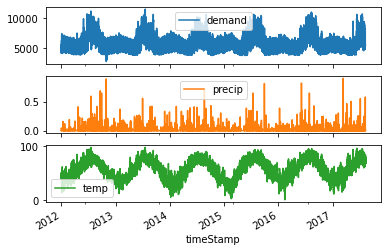

In [96]:
df_indexed.plot(subplots=True)

In [97]:
# Resampling the data frame to Day level in order to get better modelling 
df_indexed = df_indexed.resample('D').mean()
df_indexed.head()

,demand,precip,temp
timeStamp,,,
2012-01-01,4954.833333,0.002487,46.510000
2012-01-02,5302.954167,0.000000,40.496667
2012-01-03,6095.512500,0.000000,26.672500
2012-01-04,6336.266667,0.000000,20.585000
2012-01-05,6130.245833,0.000000,33.577500


array([<AxesSubplot:xlabel='timeStamp'>, <AxesSubplot:xlabel='timeStamp'>,
       <AxesSubplot:xlabel='timeStamp'>], dtype=object)

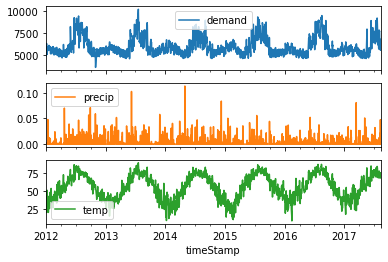

In [98]:
df_indexed.plot(subplots=True)

#### Note: From the above plots, it is evident that the existance of seasonality in both DEMAND abd TEMPERATURE variables. 
Precipitation is nearly not showing any pattern w.r.t time. So neglecting the effect of precipitation on demand

In [99]:
df_indexed.drop('precip',axis=1,inplace=True)
df_indexed.head()

,demand,temp
timeStamp,,
2012-01-01,4954.833333,46.510000
2012-01-02,5302.954167,40.496667
2012-01-03,6095.512500,26.672500
2012-01-04,6336.266667,20.585000
2012-01-05,6130.245833,33.577500


In [100]:
# Checking for null values:
df_indexed.isna().sum()

demand    2
temp      1
dtype: int64

#### Note: FBProphet can manage the nulls in the target variable, Nulls present in the remaining variables needs to be handled before implementing the model. 

In [101]:
df_indexed[df_indexed['temp'].isna()]

,demand,temp
timeStamp,,
2015-12-28,5510.776333,NaN


In [102]:
# As there is only one missing value, proceeding with ffill method 
df_indexed['temp'].fillna(method='ffill',inplace=True)
df_indexed.isna().sum()


demand    2
temp      0
dtype: int64

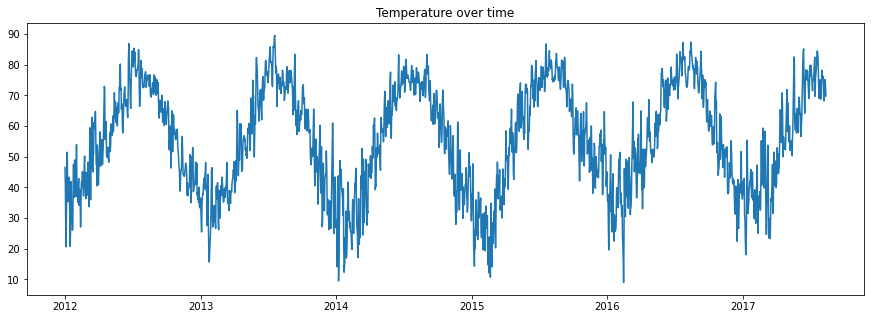

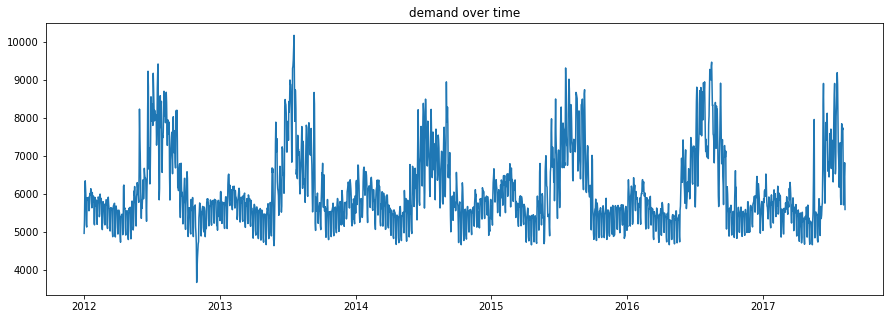

In [103]:
plt.figure(figsize=(15,5))
plt.plot(df_indexed['temp'])
plt.title("Temperature over time")
plt.show()

plt.figure(figsize=(15,5))
plt.plot(df_indexed['demand'])
plt.title("demand over time")
plt.show()

#### Note: Whenever the temperature is high, Energy consumption found to be very high, that means energy consumption is more in summer comparing to other seasons

### Analysing the temperature

In [104]:
df_indexed = df_indexed.reset_index()
df_indexed

,timeStamp,demand,temp
0,2012-01-01,4954.833333,46.510000
1,2012-01-02,5302.954167,40.496667
2,2012-01-03,6095.512500,26.672500
3,2012-01-04,6336.266667,20.585000
4,2012-01-05,6130.245833,33.577500
...,...,...,...
2046,2017-08-08,6471.626042,71.039167
2047,2017-08-09,6811.112167,73.852500
2048,2017-08-10,5582.297000,75.217500
2049,2017-08-11,NaN,72.767917


In [105]:
df_indexed['month'] = df_indexed['timeStamp'].dt.month
df_indexed

,timeStamp,demand,temp,month
0,2012-01-01,4954.833333,46.510000,1
1,2012-01-02,5302.954167,40.496667,1
2,2012-01-03,6095.512500,26.672500,1
3,2012-01-04,6336.266667,20.585000,1
4,2012-01-05,6130.245833,33.577500,1
...,...,...,...,...
2046,2017-08-08,6471.626042,71.039167,8
2047,2017-08-09,6811.112167,73.852500,8
2048,2017-08-10,5582.297000,75.217500,8
2049,2017-08-11,NaN,72.767917,8


In [106]:
# Analysing teh temp changes over the months
df_indexed.groupby('month').agg({'temp':['min','max','mean']})


temp                      
             min        max       mean
month                                 
1       9.507917  55.420455  33.432140
2       9.015000  59.360000  34.517758
3      20.291667  67.878333  41.419884
4      33.045833  72.992083  52.600204
5      48.090833  82.576250  62.543994
6      52.405833  86.916667  71.334418
7      66.417083  89.606667  77.595627
8      68.042083  87.426250  75.525947
9      57.274583  84.448750  69.550306
10     42.106250  74.277500  58.642895
11     27.172500  67.606250  47.225638
12     22.429583  64.735000  41.520068

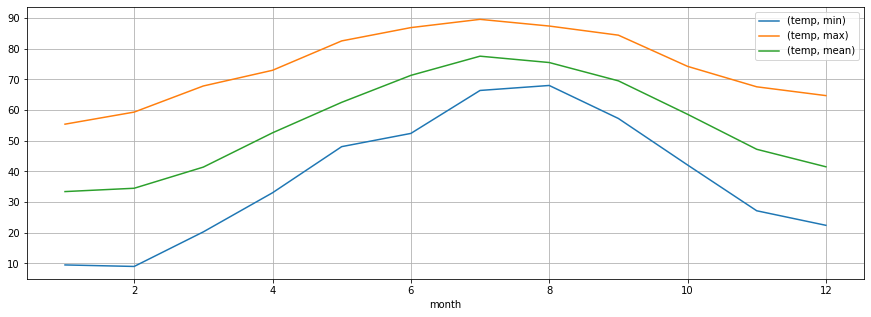

In [107]:

df_indexed.groupby('month').agg({'temp':['min','max','mean']}).plot(figsize=(15,5))
plt.legend()
plt.grid()
plt.show()

#### Note: Betwwen June and Sept the avg temp >60


In [108]:
fig = px.line(df_indexed.set_index('timeStamp'),y = 'demand',title = 'Demand Over Time')
fig.update_xaxes(rangeslider_visible=True)
fig.show()

In [109]:
# Adding an extra column that indictes 1 if the temp of the day > 70 and 0 otherwise
def high_temp_indicator(x):
    if x>70:
        return 1
    else:
        return 0

df_indexed['high_temp_indicator'] = df_indexed['temp'].apply(high_temp_indicator)
df_indexed.head()

,timeStamp,demand,temp,month,high_temp_indicator
0,2012-01-01,4954.833333,46.510000,1,0
1,2012-01-02,5302.954167,40.496667,1,0
2,2012-01-03,6095.512500,26.672500,1,0
3,2012-01-04,6336.266667,20.585000,1,0
4,2012-01-05,6130.245833,33.577500,1,0


In [110]:
# Adding one more column such that it can hold the season number
def season_holder(x):
    if x>=1 and x<=3:
        return 1
    elif x>=4 and x<=9:
        return 2
    else:
        return 3
    
df_indexed['season_holder'] = df_indexed['month'].apply(season_holder)
df_indexed.head()

,timeStamp,demand,temp,month,high_temp_indicator,season_holder
0,2012-01-01,4954.833333,46.510000,1,0,1
1,2012-01-02,5302.954167,40.496667,1,0,1
2,2012-01-03,6095.512500,26.672500,1,0,1
3,2012-01-04,6336.266667,20.585000,1,0,1
4,2012-01-05,6130.245833,33.577500,1,0,1


### Implementing the FBProphet model

In [111]:
from prophet import Prophet


In [112]:
model = Prophet(interval_width=0.95,yearly_seasonality=True)


In [113]:
# Reframing the data frame to fit FBProphet requirements
df_fb = df_indexed.copy()
df_fb.columns= ['ds','y','temp','month','high_temp_indicator','season_holder']
df_fb.head()

,ds,y,temp,month,high_temp_indicator,season_holder
0,2012-01-01,4954.833333,46.510000,1,0,1
1,2012-01-02,5302.954167,40.496667,1,0,1
2,2012-01-03,6095.512500,26.672500,1,0,1
3,2012-01-04,6336.266667,20.585000,1,0,1
4,2012-01-05,6130.245833,33.577500,1,0,1


In [114]:
# Splitting into train and testing sets
train = df_fb[(df_fb['ds'] >= '2012-01-01')& (df_fb['ds']<='2017-04-30') ]
test = df_fb[df_fb['ds']>'2017-04-30']

In [115]:
# Adding other variables as regressors
model.add_regressor('high_temp_indicator',standardize=False)
model.add_regressor('season_holder', standardize=True)


In [116]:
# Fitting the TRAINING DATA
# Fitting the TRAINING data to the model 
model.fit(train)


17:42:36 - cmdstanpy - INFO - Chain [1] start processing
17:42:36 - cmdstanpy - INFO - Chain [1] done processing


In [117]:
model.params

OrderedDict([('lp__', array([[5226.97]])),
             ('k', array([[0.207639]])),
             ('m', array([[0.563272]])),
             ('delta',
              array([[ 8.91188e-08, -3.02943e-05, -2.65199e-01, -2.91396e-08,
                       5.28985e-08,  4.19079e-02,  4.09273e-06,  4.14538e-08,
                      -2.03850e-07,  4.76781e-08, -2.06636e-07, -1.31334e-01,
                      -5.02895e-04, -1.11547e-07,  2.97372e-01,  2.84787e-09,
                       1.15587e-07, -1.86613e-01, -3.74331e-08, -4.45023e-08,
                       2.99117e-08,  4.70540e-09,  3.86354e-02,  8.15973e-03,
                       5.82887e-08]])),
             ('sigma_obs', array([[0.0409655]])),
             ('beta',
              array([[-0.0223992 , -0.0309077 ,  0.0344544 ,  0.0305469 , -0.00790956,
                      -0.00401602, -0.002093  ,  0.00068364, -0.0024574 , -0.00591296,
                       0.00356458,  0.00113661, -0.00630111, -0.00244758,  0.00436041,
           

### Creating future data frame

In [118]:
future_df = model.make_future_dataframe(periods=104)
future_df.tail()

,ds
2046,2017-08-08
2047,2017-08-09
2048,2017-08-10
2049,2017-08-11
2050,2017-08-12


In [119]:
# Incorporating the other 2 variables (high_temp_indicator, season_holder)
# Using the historic values
future_df['high_temp_indicator'] = df_indexed['high_temp_indicator']
future_df['season_holder'] = df_indexed['season_holder']
future_df.head()

,ds,high_temp_indicator,season_holder
0,2012-01-01,0,1
1,2012-01-02,0,1
2,2012-01-03,0,1
3,2012-01-04,0,1
4,2012-01-05,0,1


### Forecasting

In [120]:
forecast = model.predict(future_df)


In [121]:
forecast_df = forecast[['ds','yhat','yhat_lower','yhat_upper']]
forecast_df

,ds,yhat,yhat_lower,yhat_upper
0,2012-01-01,5097.267004,4307.214240,5923.094230
1,2012-01-02,5799.607560,4968.844216,6697.535844
2,2012-01-03,5883.615470,5148.575986,6688.406932
3,2012-01-04,5896.291437,5074.569727,6700.876486
4,2012-01-05,5879.014054,5118.142164,6695.163927
...,...,...,...,...
2046,2017-08-08,7584.936883,6775.891287,8415.016787
2047,2017-08-09,7581.596224,6770.855313,8371.388810
2048,2017-08-10,7550.342287,6761.954484,8359.059572
2049,2017-08-11,7512.791580,6731.851247,8385.288759


### Visualising the forecasting

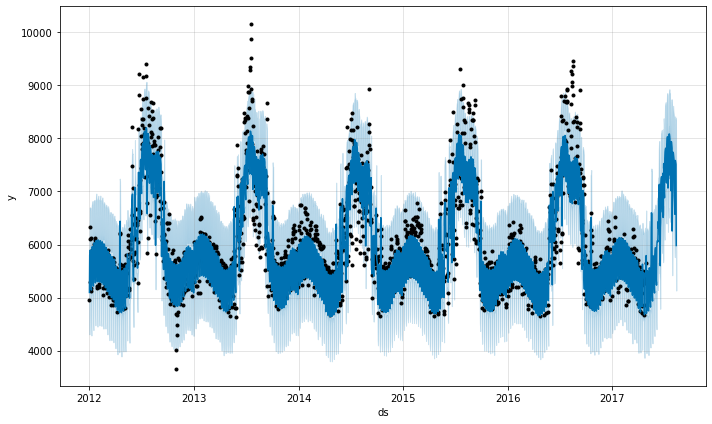

In [122]:
model.plot(forecast);

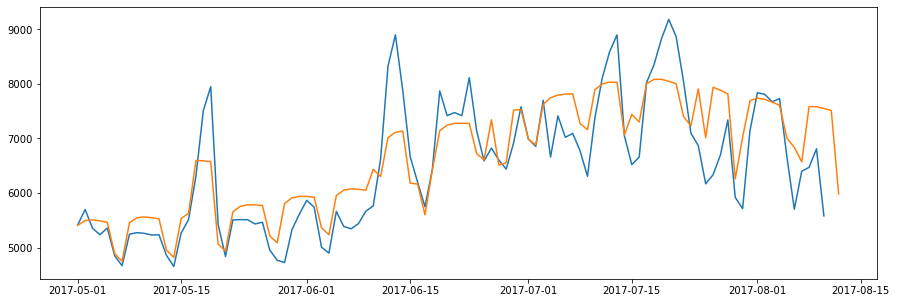

In [130]:
plt.figure(figsize=(15,5))
plt.plot(test.set_index('ds')['y'])
plt.plot(forecast_df.set_index('ds').loc['2017-05-01':]['yhat'])


### Crossvalidating for comparison

In [131]:
from prophet.diagnostics import cross_validation
cv_df = cross_validation(model,initial='800 days',horizon='365 days')
cv_df

  0%|          | 0/5 [00:00<?, ?it/s]

17:50:56 - cmdstanpy - INFO - Chain [1] start processing
17:50:57 - cmdstanpy - INFO - Chain [1] done processing
17:50:57 - cmdstanpy - INFO - Chain [1] start processing
17:50:57 - cmdstanpy - INFO - Chain [1] done processing
17:50:58 - cmdstanpy - INFO - Chain [1] start processing
17:50:58 - cmdstanpy - INFO - Chain [1] done processing
17:50:58 - cmdstanpy - INFO - Chain [1] start processing
17:50:59 - cmdstanpy - INFO - Chain [1] done processing
17:50:59 - cmdstanpy - INFO - Chain [1] start processing
17:50:59 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2014-05-02,5590.749293,4864.290101,6272.733582,5460.325000,2014-05-01
1,2014-05-03,4990.832499,4261.721795,5724.313653,4893.683333,2014-05-01
2,2014-05-04,4847.576937,4142.886789,5567.125464,4764.137500,2014-05-01
3,2014-05-05,5558.755269,4870.840141,6320.060966,5406.762500,2014-05-01
4,2014-05-06,5613.271856,4777.580673,6351.786460,5409.750000,2014-05-01
...,...,...,...,...,...,...
1820,2017-04-26,5192.465934,4183.714503,6044.164309,5342.687591,2016-04-30
1821,2017-04-27,5152.094140,4167.306624,6074.301139,5445.442917,2016-04-30
1822,2017-04-28,5110.874664,4155.152038,6078.234929,5648.995917,2016-04-30
1823,2017-04-29,5482.253040,4490.286544,6393.994119,5467.143125,2016-04-30


In [132]:
from prophet.diagnostics import performance_metrics
performance_metrics(cv_df)

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,36 days 12:00:00,171223.788899,413.791963,314.515847,0.056952,0.044502,0.056162,0.950549
1,37 days 00:00:00,177191.469960,420.941172,320.427015,0.058016,0.044502,0.057113,0.945055
2,37 days 12:00:00,178935.461767,423.007638,322.830638,0.058414,0.046204,0.057541,0.945055
3,38 days 00:00:00,179349.732217,423.497027,323.966419,0.058421,0.046204,0.057489,0.945055
4,38 days 12:00:00,182196.000582,426.844235,328.119424,0.059068,0.048398,0.058164,0.945055
...,...,...,...,...,...,...,...,...
653,363 days 00:00:00,223787.120730,473.061434,412.771330,0.076689,0.074668,0.076042,0.983516
654,363 days 12:00:00,224455.803534,473.767668,412.251980,0.076590,0.074668,0.076048,0.983516
655,364 days 00:00:00,225561.892225,474.933566,413.314507,0.076880,0.074711,0.076262,0.983516
656,364 days 12:00:00,224559.319130,473.876903,411.958585,0.076659,0.074711,0.076130,0.983516


In [133]:
performance_metrics(cv_df).mean()

horizon     200 days 18:00:00
mse             387490.025029
rmse               602.366576
mae                480.645362
mape                 0.076748
mdape                0.067054
smape                0.076196
coverage             0.847543
dtype: object

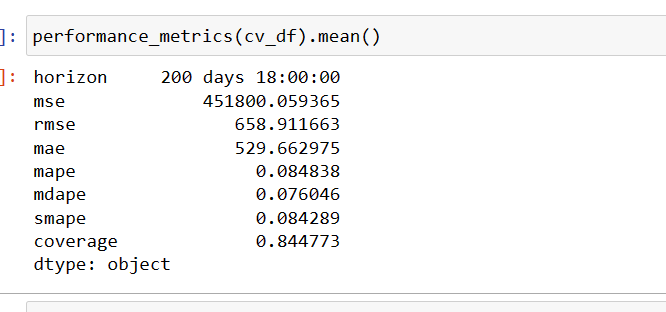

In [137]:
## Metrics from univariant FB prophet modelling
from IPython import display
display.Image("C:/Users/prasa/Dropbox/PC/Desktop/ML-Projects/TSA/FBprophet/FBProphet_univariant_metrics.PNG")